In [1]:
import cv2
import numpy as np
from pdf2image import convert_from_path
from docx import Document
import matplotlib.pyplot as plt
import os


In [2]:
def load_invoice_as_image(file_path, poppler_path):
    ext = os.path.splitext(file_path)[1].lower()

    if ext == ".pdf":
        pages = convert_from_path(file_path, poppler_path=poppler_path)
        invoice_img = np.array(pages[0])[:, :, ::-1]   # convert RGB → BGR
        return invoice_img

    elif ext in [".docx", ".doc"]:
        doc = Document(file_path)
        text = "\n".join([p.text for p in doc.paragraphs])

        img = np.ones((1200, 900, 3), dtype=np.uint8) * 255
        y = 40
        for line in text.split("\n"):
            cv2.putText(img, line, (30, y), cv2.FONT_HERSHEY_SIMPLEX,
                        0.8, (0, 0, 0), 2)
            y += 35
        return img

    else:
        raise ValueError("Unsupported file format: " + ext)


In [3]:
def detect_text_blocks(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 3))
    dilated = cv2.dilate(thresh, kernel, iterations=3)

    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxes = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if w > 40 and h > 20:  # remove noise
            boxes.append((x, y, w, h))
    return boxes


In [4]:
def categorize_blocks(boxes, img_height):
    header, table, totals = [], [], []

    for x, y, w, h in boxes:
        if y < img_height * 0.25:
            header.append((x, y, w, h))
        elif y < img_height * 0.75:
            table.append((x, y, w, h))
        else:
            totals.append((x, y, w, h))

    return header, table, totals


In [5]:
def draw_bounding_boxes(img, header, table, totals):
    out = img.copy()

    # header → blue
    for (x, y, w, h) in header:
        cv2.rectangle(out, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # table → green
    for (x, y, w, h) in table:
        cv2.rectangle(out, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # totals → red
    for (x, y, w, h) in totals:
        cv2.rectangle(out, (x, y), (x+w, y+h), (0, 0, 255), 2)

    return out


In [6]:
def process_invoice(file_path, poppler_path):
    img = load_invoice_as_image(file_path, poppler_path)
    boxes = detect_text_blocks(img)

    h, w = img.shape[:2]
    header, table, totals = categorize_blocks(boxes, h)

    final_img = draw_bounding_boxes(img, header, table, totals)
    return final_img


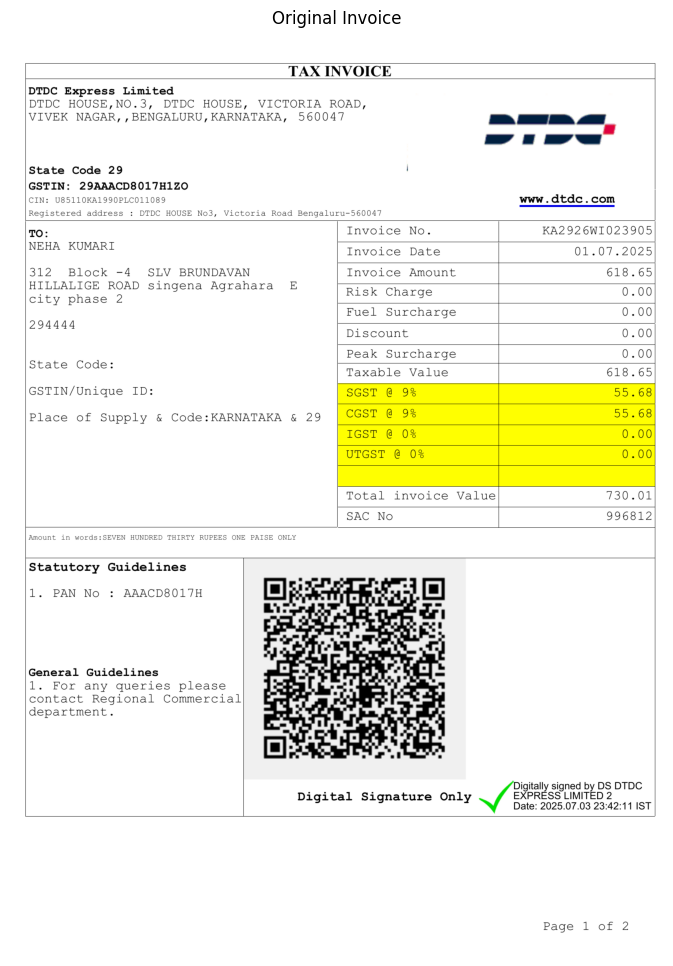

In [7]:

img_invoice = load_invoice_as_image("invoice.pdf",poppler_path=r"poppler-25.11.0\Library\bin")

plt.figure(figsize=(10, 12))
plt.imshow(cv2.cvtColor(img_invoice, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Original Invoice")
plt.show()


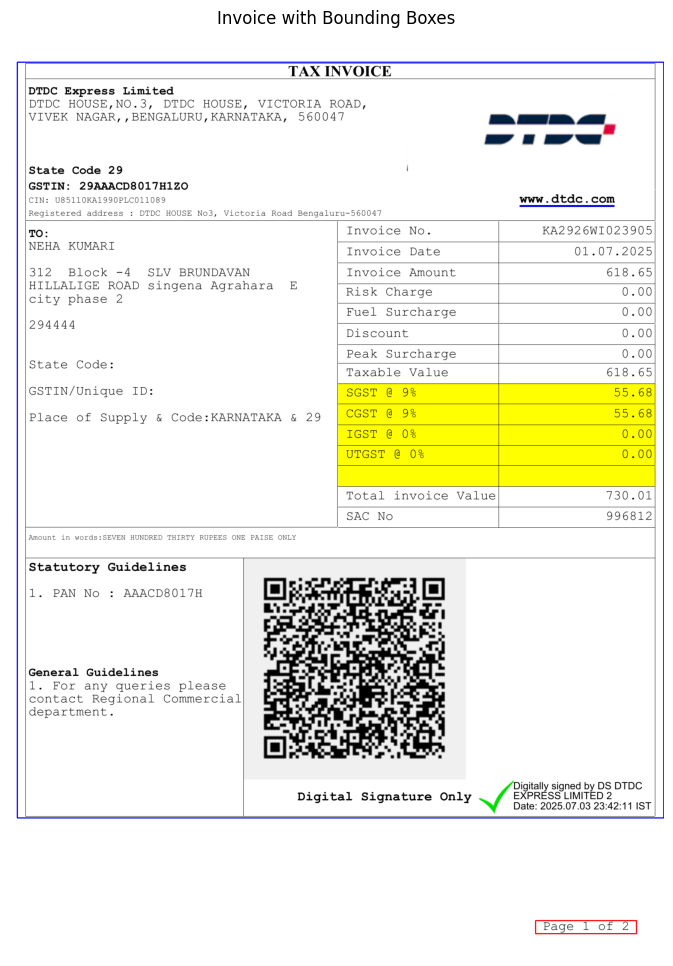

In [8]:
final_img = process_invoice(
    "invoice.pdf",
    poppler_path=r"poppler-25.11.0\Library\bin"
)

plt.figure(figsize=(10, 12))
plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Invoice with Bounding Boxes")
plt.show()
